## **Plot**

In [12]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [66]:
with open("results/INSAR_20200909_PSDS_v3/PATCH_1/pscands.1.ll", "r") as f:
    ll = np.loadtxt(f)


In [ ]:
# Plot the lon/lat points
plt.figure(figsize=(20,10))
plt.scatter(ll[:,0], ll[:,1], s=1, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('PS Candidate Locations')
plt.grid(True)
plt.show()

# Split into lon/lat arrays for later use
lon = ll[:,0] 
lat = ll[:,1]


In [70]:
pm1 = sio.loadmat("results/INSAR_20200909_PSDS_v3/PATCH_1/pm1.mat")
ps2 = sio.loadmat("results/INSAR_20200909_PSDS_v3/ph2.mat")
ij = ps2['ps']['ij'][0][0].astype(int)
lonlat = ps2['ps']['lonlat'][0][0]
selected_ph = pm1['ph_patch'][ij[:, 0], :]


In [21]:
ph2 = sio.loadmat("results/INSAR_20200909_PSDS_v3/ph2.mat")
ps2 = ps2 = sio.loadmat("results/INSAR_20200909_PSDS_v3/ps2.mat")
ij = ps2['ij'].astype(int) - 1
lonlat = ps2['lonlat']
selected_ph = ph2['ph'][ij[:, 0], :]

In [ ]:
# Plot selected phase values at their pixel locations
plt.figure(figsize=(20,12))

# Use viridis colormap with increased point size and alpha
plt.scatter(lonlat[:, 0], lonlat[:, 1], 
           c=np.angle(selected_ph[:,0]),
           cmap='viridis', 
           s=1,  # Increased marker size
           alpha=0.7)  # Increased opacity

# Add a more visible colorbar
cbar = plt.colorbar(label='Phase (rad)')
cbar.ax.tick_params(labelsize=12)

# Enhance axis labels and title
plt.xlabel('Range pixel', fontsize=14)
plt.ylabel('Azimuth pixel', fontsize=14)
plt.title('Selected Phase Values at Pixel Locations', fontsize=16, pad=15)

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.show()



In [ ]:
# Get number of interferograms
n_ifg = pm1['ph_patch'].shape[1]

# Create subplot grid
n_rows = int(np.ceil(np.sqrt(n_ifg)))
n_cols = int(np.ceil(n_ifg / n_rows))

plt.figure(figsize=(4*n_cols, 4*n_rows))

# Plot phase for each interferogram
for i in range(n_ifg):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(np.angle(pm1['ph_patch'][:,i]).reshape(-1,1), aspect='auto', cmap='hsv')
    plt.colorbar(label='Phase (rad)')
    plt.title(f'Interferogram {i+1}')
    plt.xlabel('PS Point')

plt.tight_layout()
plt.show()


## **Data**

In [1]:
import numpy as np
from modules.tomo.input_parm import Input

In [ ]:
filepath = "results/INSAR_20200909_PSDS_v3/diff0/20200909_20200723.psds"
with open(filepath, "rb") as f:
    data = np.fromfile(f, dtype=np.complex64)
data.reshape((401, 2117))
data


In [16]:
filepath = "results/INSAR_20200909_PSDS_v3/shp.npz"
shp_data = np.load(filepath, allow_pickle=True)['shp'].item()['patches']

In [ ]:
for idx, item in enumerate(shp_data):
    print(f'{idx}: {item["BroNum"].shape}')

In [ ]:
slc, interf = Input([7, 25], output=False).run()

In [ ]:
slc['datastack'][0]['datastack'].shape

In [ ]:
filepath = "results/INSAR_20200909_PSDS_v3/coherence.npz"
coherence_data = np.load(filepath, allow_pickle=True)['coherence']

for idx, item in enumerate(coherence_data):
    print(f'{idx}: {item["coherence"].shape}')








In [1]:
from config._0_engage import Initialize
import os

In [2]:
try:
    bbox = [106.6969, 10.7615, 106.7275, 10.7945]
    init = Initialize(bbox, "DESCENDING", 540, project_name="default")
except Exception as e:
    print(f"Engage project structure fails due to\n{e}\n")

In [ ]:
init.config_parser.get_project_config("default")

## **RMSE**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
file = r"data\geom\INSAR_20250110_PSDS_v11_PATCH_1.csv"

In [ ]:
# === Step 1: Load CSV ===
df = pd.read_csv(file)
df = df.loc[df['COHERENCE'] > 0.7]
# Identify columns
vlos = df['VLOS'].values
coh = df['COHERENCE'].values
disp_cols = [col for col in df.columns if col.startswith('D')]
ts = df[disp_cols].values  # shape: (n_points, n_times)

# === Step 2: Remove rows with NaN in VLOS ===
valid_mask = ~np.isnan(vlos)
vlos_valid = vlos[valid_mask]
coh_valid = coh[valid_mask]
ts_valid = ts[valid_mask, :]  # shape: (n_valid_points, n_times)

# Transpose time-series for modeling
ts_valid_T = ts_valid.T  # shape: (n_times, n_valid_points)
n_times, n_pts = ts_valid_T.shape

# === Step 3: Fit Weighted Linear Model ===
time = np.arange(n_times).reshape(-1, 1)  # Simple index as time (0, 1, ..., n-1)
vlos_est = np.zeros(n_pts)
rmse_list = np.zeros(n_pts)

for i in range(n_pts):
    y = ts_valid_T[:, i]
    w = np.full_like(y, coh_valid[i])  # same weight over all time steps

    A = np.hstack([time, np.ones_like(time)])
    # W = np.diag(w)

    # Weighted least squares fit: theta = [slope, intercept]
    theta = np.linalg.lstsq(A, y, rcond=None)[0]

    vlos_est[i] = theta[0]
    y_pred = A @ theta
    rmse_list[i] = np.sqrt(np.mean((y - y_pred) ** 2))

# === Step 4: Compute RMSE between original and estimated VLOS ===
rmse_vlos = np.sqrt(mean_squared_error(vlos_valid, vlos_est))
print(f"RMSE between original and estimated VLOS: {rmse_vlos:.4f} mm/year")

# === Step 5: Average time-series fitting RMSE ===
mean_rmse_ts = np.mean(rmse_list)
print(f"Mean RMSE of time-series fits: {mean_rmse_ts:.4f} mm")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

coh_valid = coh[valid_mask].reshape(-1, 1)
vlos_valid = vlos[valid_mask]

model = LinearRegression().fit(coh_valid, vlos_valid)
vlos_pred = model.predict(coh_valid)

plt.scatter(coh_valid, vlos_valid, alpha=0.3, label='VLOS')
plt.plot(coh_valid, vlos_pred, color='red', label='Linear Fit')
plt.xlabel("Coherence")
plt.ylabel("VLOS (mm/year)")
plt.title("VLOS vs Coherence")
plt.legend()
plt.show()

print(f"R² score: {model.score(coh_valid, vlos_valid):.4f}")


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load your CSV
df = pd.read_csv(file)  # replace with your filename

# Identify displacement columns
disp_cols = [col for col in df.columns if col.startswith('D')]
dates = [pd.to_datetime(col.replace('D', '')) for col in disp_cols]
time_decimal = np.array([d.year + d.dayofyear / 365.25 for d in dates])
time_decimal = time_decimal - time_decimal[0]  # time since first acquisition (in years)

# Get displacement matrix
ts = df[disp_cols].values
n_points, n_times = ts.shape

vlos_est = np.full(n_points, np.nan)
rmse_fit = np.full(n_points, np.nan)
r2_fit = np.full(n_points, np.nan)

for i in range(n_points):
    y = ts[i, :]
    if np.any(np.isnan(y)):
        continue

    t = time_decimal.reshape(-1, 1)
    model = LinearRegression().fit(t, y)
    y_pred = model.predict(t)

    vlos_est[i] = model.coef_[0]
    rmse_fit[i] = np.sqrt(np.mean((y - y_pred)**2))
    r2_fit[i] = r2_score(y, y_pred)

# Add results to DataFrame
df["vlos_est"] = vlos_est
df["rmse_fit"] = rmse_fit
df["r2_fit"] = r2_fit


C:\Users\nhatd\AppData\Local\Temp\ipykernel_12948\4247171451.py:8: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)  # replace with your filename


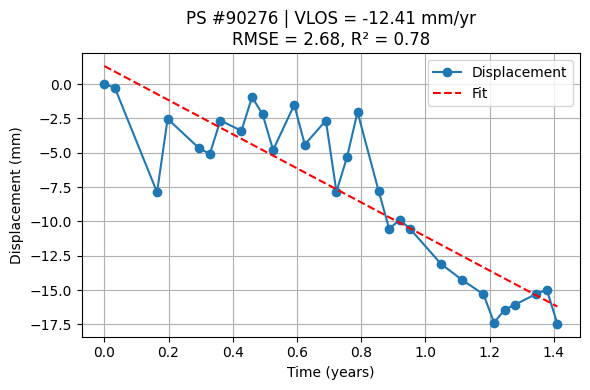

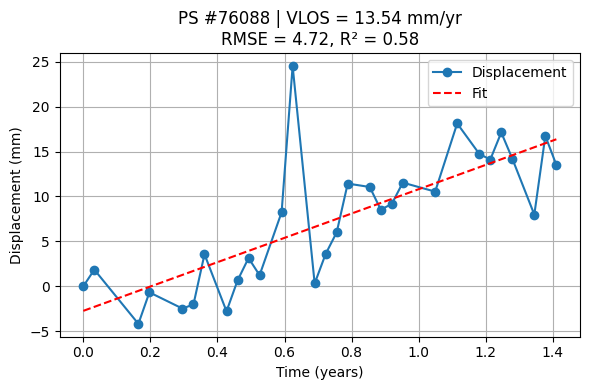

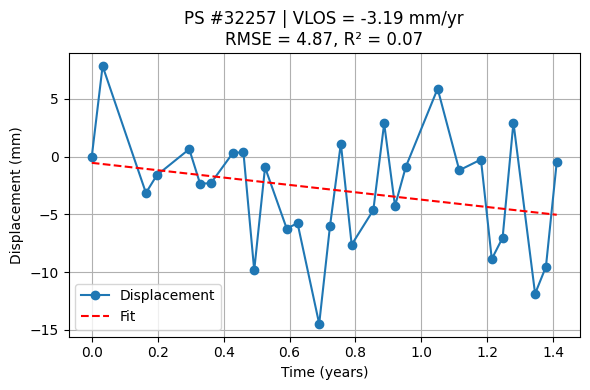

In [19]:
# Plot 3 random good fits
valid_idx = np.where(~np.isnan(vlos_est))[0]
sample_idx = np.random.choice(valid_idx, size=3, replace=False)

for idx in sample_idx:
    y = ts[idx, :]
    t = time_decimal
    model = LinearRegression().fit(t.reshape(-1,1), y)
    y_pred = model.predict(t.reshape(-1,1))
    
    plt.figure(figsize=(6, 4))
    plt.plot(t, y, 'o-', label='Displacement')
    plt.plot(t, y_pred, 'r--', label='Fit')
    plt.title(f"PS #{idx} | VLOS = {vlos_est[idx]:.2f} mm/yr\nRMSE = {rmse_fit[idx]:.2f}, R² = {r2_fit[idx]:.2f}")
    plt.xlabel("Time (years)")
    plt.ylabel("Displacement (mm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
